In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import sympy as sp
import HOHWM

Linear Fredholm integral equations (HOHWM s = 1)




In [17]:
def Fredholm_1st_iterative_method(
    N, f, K, method="GMRES", tol=1e-8, max_iter=100, verbose=False
):
    # define the system of equations for the iterative method
    def sys_eqs(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        eqs = np.zeros(N)

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        # Haar part
        M_A = np.zeros((N, N))
        for j in range(N):
            for k in range(N):
                M_A[:, j] += K(x, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        M_A = HOHWM.haar_int_1_mat(x, N) - 1 / N * M_A

        V_B = np.zeros(N)
        for k in range(N):
            V_B += K(x, t[k])
        V_B = 1 - 1 / N * V_B

        eqs = np.dot(M_A, coef_haar) - (
            f(x) - 1 / (1 - S_2) * (f(0) + np.dot(coef_haar, S_1)) * V_B
        )

        return eqs

    def Jac(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        jac = np.zeros((N, N))

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        M_A = np.zeros((N, N))
        for j in range(N):
            for k in range(N):
                M_A[:, j] += K(x, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        M_A = HOHWM.haar_int_1_mat(x, N) - 1 / N * M_A

        V_B = np.zeros(N)
        for k in range(N):
            V_B += K(x, t[k])
        V_B = 1 - 1 / N * V_B

        jac = M_A + 1 / (1 - S_2) * np.outer(V_B, S_1)

        return jac

    def newton(coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose):
        coef_haar = coef_haar.copy()
        
        # iter number
        iter = 0

        for i in range(max_iter):
            F = sys_eqs(coef_haar)
            J = Jac(coef_haar)

            if method == "LU":
                delta = np.linalg.solve(J, -F)  # LU
            elif method == "CG":
                delta = sla.cg(J, -F)[0]
            elif method == "GMRES":
                delta = sla.gmres(J, -F)[0]
            elif method == "MINRES":
                delta = sla.minres(J, -F)[0]
            else:
                raise NotImplementedError("Only support LU, CG, GMRES, MINRES")

            coef_haar += delta
            iter += 1

            if np.linalg.norm(delta) < tol:
                break
        if verbose:
            print("iter: ", iter)
            # print("delta: ", delta)
            # print("coefs: ", coefs)

        if iter == max_iter:
            print("Warning: Newton's method does not converge!")

        return coef_haar
    
    
    coef_haar = np.zeros(N) # initial guess
    coef_haar = newton(coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose)
    
    
    # compute constant C1
    x = HOHWM.collocation(N)
    t = HOHWM.collocation(N)

    S_1 = np.zeros(N)
    for j in range(N):
        for k in range(N):
            S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
    S_1 = 1 / N * S_1

    S_2 = 0
    for k in range(N):
        S_2 += K(0, t[k])
    S_2 = 1 / N * S_2

    C_1 = 1 / (1 - S_2) * (f(0) + np.dot(coef_haar, S_1))
    
    
    # define approximated function
    def u_haar_approx_func(x):
        # superposition of the Haar wavelet functions
        approx_func_val = C_1
        for k in range(N):
            approx_func_val += coef_haar[k] * HOHWM.haar_int_1(x, k + 1)
        return approx_func_val

    return u_haar_approx_func

In [29]:
f = lambda x: 9/10 * x**2
K = lambda x, t: 1/2 * (x**2 * t**2)
u_true = lambda x: x**2

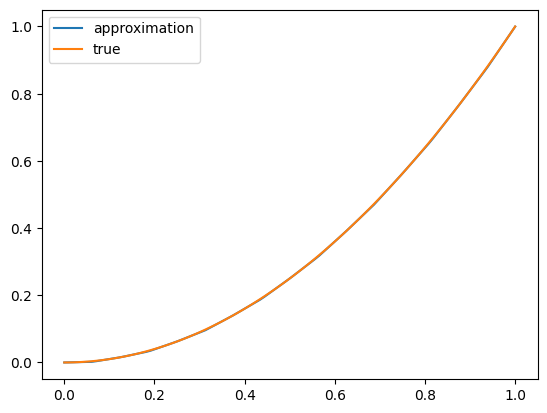

In [30]:
# plot the approximated function
u_approx_func = Fredholm_1st_iterative_method(16, f, K, method="GMRES", tol=1e-8, max_iter=100, verbose=False)
x = np.linspace(0, 1, 100)
y = u_approx_func(x)
plt.plot(x, y, label="approximation")
plt.plot(x, u_true(x), label="true")
plt.legend()
plt.show()

In [31]:
# Compute the error
print_results = True
if print_results is True:
    print("Iterative method for linear Fredholm equation")
    
    col_size = [2, 4, 8, 16, 32, 64]
    err_local = np.zeros(len(col_size))
    err_global = np.zeros(len(col_size))

    for s in ["1st"]:
        
        for M in col_size:
            
            if s == "1st":
                u_approx_func = Fredholm_1st_iterative_method(M, f, K)
            elif s == "2nd":
                u_approx_func = Fredholm_2nd_iterative_method(M, f, K)
            else:
                raise ValueError("method can only be 1st or 2nd")
            x = HOHWM.collocation(M)
            test_x = x[int(M / 2)]
            u_true_half = u_true(test_x)
            u_haar_approx_half = u_approx_func(test_x)
            # store the error
            err_local[col_size.index(M)] = abs(u_true_half - u_haar_approx_half)
            # compute the global error with zero-norm
            u_true_vec = u_true(x)
            u_haar_approx_vec = u_approx_func(x)

        # print the error
        print("\n")
        print("Linear Fredholm ({} derivative)".format(s))
        print("Error at {}: ".format(test_x), err_local)
        print(
            "Experimental rate of convergence: ",
            np.diff(np.log(err_local)) / np.log(2),
        )

Iterative method for linear Fredholm equation


Linear Fredholm (1st derivative)
Error at 0.5078125:  [0.012 0.002 0.    0.    0.004 0.005]
Experimental rate of convergence:  [-2.454 -2.286 -2.16   5.356  0.136]
